In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict
import cv2


from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

sys.path.append('..')

from dataset.artificial_dataset import ArtificialDatasetReader
from utils.metrics import mse, psnr
from models.baseline import Baseline

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(0)

# Get Data

In [4]:
dr = ArtificialDatasetReader()

In [5]:
x_train, y_train, x_val, y_val, _, _ = dr.get_dataset(img_size=64)

In [6]:
x_train[0].shape, y_train[0].shape

((32, 32), (64, 64))

In [7]:
len(x_train)

1064

In [8]:
y_train[99]

array([[-0.00251417, -0.00253005, -0.0025388 , ..., -0.0026701 ,
        -0.00265251, -0.00264488],
       [-0.00252676, -0.00254714, -0.00256071, ..., -0.00266088,
        -0.00264404, -0.00263644],
       [-0.00255513, -0.00257837, -0.00259399, ..., -0.00263924,
        -0.00262293, -0.00261613],
       ...,
       [-0.00302185, -0.00339033, -0.00365163, ..., -0.00267665,
        -0.00264704, -0.00264219],
       [-0.00226736, -0.00274019, -0.0030899 , ..., -0.00265954,
        -0.00262638, -0.00261753],
       [-0.00115946, -0.00174825, -0.00221228, ..., -0.00263574,
        -0.00259876, -0.00258512]], dtype=float32)

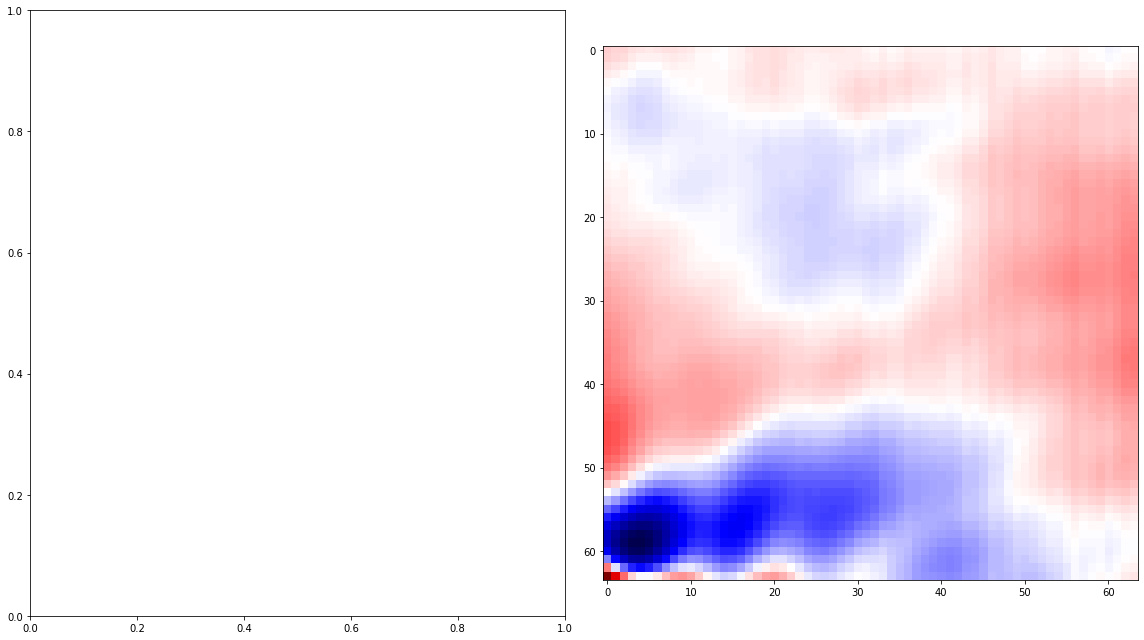

In [9]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

# ax[0].imshow(cv2.resize(y_train[99], (y_train[99].shape[1] // 2, y_train[99].shape[0] // 2),
#                         interpolation=cv2.CAP_PROP_SATURATION), cmap='seismic')

ax[1].imshow(y_train[99], cmap='seismic')

plt.tight_layout()
plt.show()

# MLP

In [10]:
tf.keras.backend.set_floatx('float32')

class MLP(tf.keras.Model):
    def __init__(self, int_dims, original_dim=64, learning_rate=0.001, activ_hidden=tf.nn.relu, activ_out=None):
        super(MLP, self).__init__()
        
        self.resolution = original_dim
        
        self.activation_hidden_layer = activ_hidden
        self.activation_output_layer = activ_out
        
        self.hidden_layers = []

        for i in range(len(int_dims)):
            self.hidden_layers.append(tf.keras.layers.Dense(
                units=int_dims[i],
                activation=activ_hidden,
                kernel_initializer='he_uniform'))
        
        self.output_layer = tf.keras.layers.Dense(
                units=self.resolution**2,
                activation=activ_out,
                kernel_initializer='he_uniform')
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.loss_metric = tf.keras.metrics.MeanAbsoluteError()
        
        self.loss = tf.keras.losses.MeanAbsoluteError()
        
        self.log_metrics = defaultdict(list)
        
        self.learning_rate = learning_rate

    def call(self, input_features):
        result = tf.reshape(input_features, (-1, (self.resolution//2)**2))
        for i in range(len(self.hidden_layers)):
            result = self.hidden_layers[i](result)
        
        out = self.output_layer(result)
        
        return tf.reshape(out, (-1, self.resolution, self.resolution))

    @tf.function
    def train(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x)
            
            loss_value = self.loss(predictions, y)
            
            self.loss_metric.update_state(predictions, y)
                        
            gradients = tape.gradient(loss_value, self.trainable_variables)
            
            gradient_variables = zip(gradients, self.trainable_variables)
            
            self.optimizer.apply_gradients(gradient_variables)
            
            return loss_value

    def make_dataset(self, x, y, x_val, y_val):
        x_train = tf.data.Dataset.from_tensor_slices(x)
        x_val = tf.data.Dataset.from_tensor_slices(x_val)
        
        y_train = tf.data.Dataset.from_tensor_slices(y)
        y_val = tf.data.Dataset.from_tensor_slices(y_val)
            
        return x_train, y_train, x_val, y_val

    def train_epochs(self, x_train, y_train, x_val, y_val, n_epochs, batch_size, SEED=42):
        x_val_original = x_val
        y_val_original = y_val
        x_train, y_train, x_val, y_val = self.make_dataset(x_train, y_train, x_val, y_val)
        loss = []
        for epoch in range(n_epochs):
            loss_val = []
            batches_x = x_train.batch(batch_size)
            batches_y = y_train.batch(batch_size)
            
            # Training loop
            for _x, _y in zip(batches_x, batches_y):
                self.train( _x, _y)
            
            batches_x_val = x_val.batch(batch_size)
            batches_y_val = y_val.batch(batch_size)
            
            # Validation loop
            for _x, _y in zip(batches_x, batches_y):
                loss_val.append(self.loss(self(_x), _y))

            loss_train = self.loss_metric.result().numpy()
            
            if epoch%5 == 0 or epoch == 0:
                psnr(y_val_original, self(x_val_original))
                print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
            loss.append(np.mean(loss_val))

            self.log_metrics['loss_train'].append(loss_train)
            self.log_metrics['loss_val'].append(np.mean(loss_val))

            self.loss_metric.reset_states()
        
        psnr(y_val_original, self(x_val_original))
        print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
        return pd.DataFrame(self.log_metrics)



In [29]:
model = MLP([512], learning_rate=0.0001, activ_hidden=tf.nn.tanh, activ_out=tf.nn.tanh)

In [30]:
_ = model(np.random.random_sample((1, 32, 32)))

model.summary()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Model: "mlp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  524800    
_________________________________________________________________
dense_3 (Dense)              multiple                  2101248   
_________________________________________________________________
mean_absolute_error (MeanAbs multiple                  2         
Total params: 2,626,050
Trainab

## Train

In [60]:
result = model.train_epochs(x_train, y_train, x_val, y_val, 200, 64)

Mean PSNR 54.6619688602423
Epoch: 0 Train Loss: 0.0014229901134967804 Validation Loss: 0.0014093808131292462
Mean PSNR 54.701409794683066
Epoch: 5 Train Loss: 0.0014083575224503875 Validation Loss: 0.00139355449937284
Mean PSNR 54.70561782360161
Epoch: 10 Train Loss: 0.0014028282603248954 Validation Loss: 0.0013852125266566873
Mean PSNR 54.707082561028244
Epoch: 15 Train Loss: 0.0013951300643384457 Validation Loss: 0.0013821000466123223
Mean PSNR 54.75340636293824
Epoch: 20 Train Loss: 0.001397984684444964 Validation Loss: 0.001376843429170549
Mean PSNR 54.70825540904395
Epoch: 25 Train Loss: 0.001387211261317134 Validation Loss: 0.001380648580379784
Mean PSNR 54.75674589306228
Epoch: 30 Train Loss: 0.0013847514055669308 Validation Loss: 0.0013676544185727835
Mean PSNR 54.725906979286435
Epoch: 35 Train Loss: 0.001388991717249155 Validation Loss: 0.0013811347307637334
Mean PSNR 54.73911017632916
Epoch: 40 Train Loss: 0.0013919464545324445 Validation Loss: 0.001374068553559482
Mean PSNR

<AxesSubplot:>

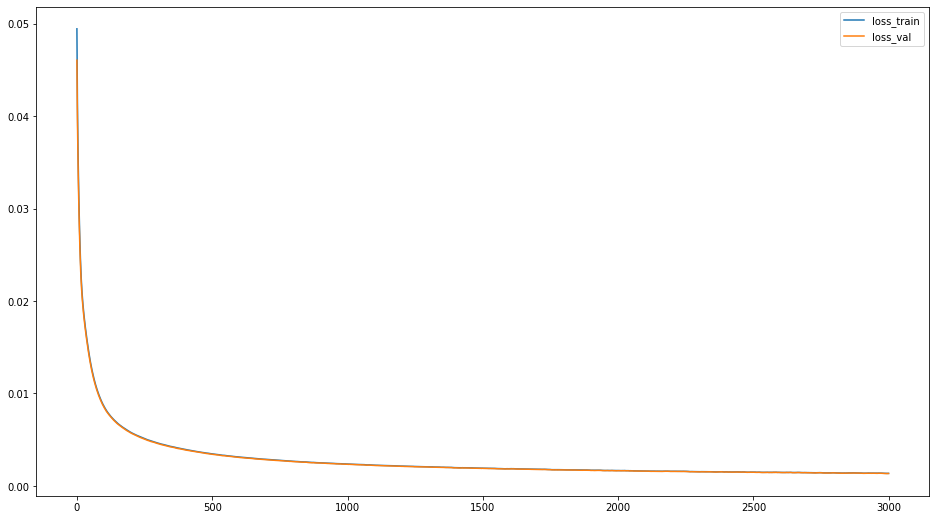

In [61]:
result.plot()

<AxesSubplot:>

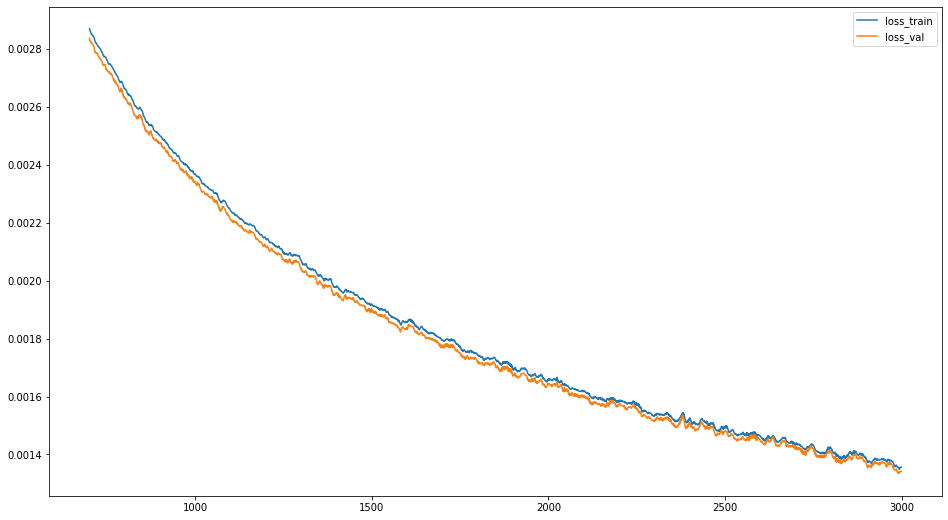

In [68]:
result[700:].plot()

In [63]:
y = model(x_val)

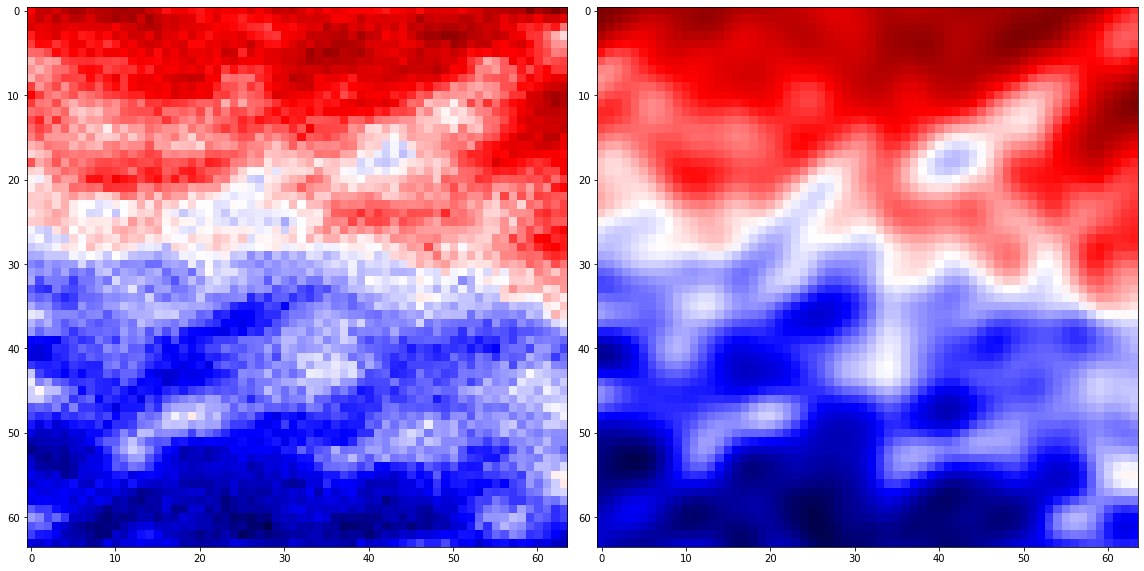

In [64]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[1], cmap='seismic')

ax[1].imshow(y_val[1], cmap='seismic')

plt.tight_layout()
plt.show()

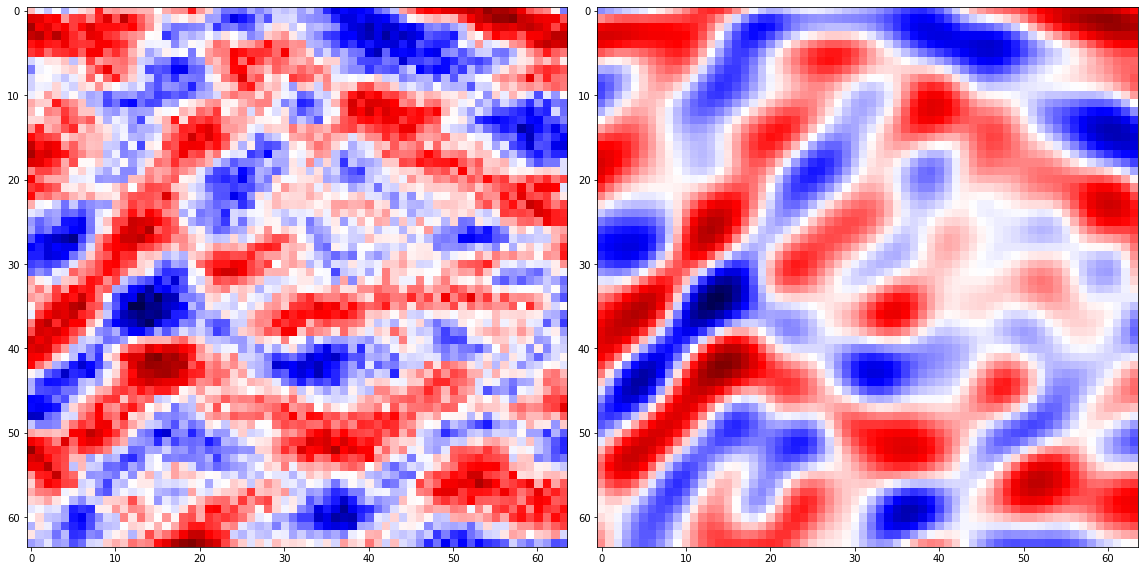

In [65]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[21], cmap='seismic')

ax[1].imshow(y_val[21], cmap='seismic')

plt.tight_layout()
plt.show()

In [66]:
_ = mse(y_val, y)
_ = psnr(y_val, y)

Mean MSE 0.00025969297357142113
Mean PSNR 54.90426769657242


### Baseline

In [19]:
baseline = Baseline()
y_b = baseline.predict(x_val)
_ = baseline.evaluate(x_val, y_val)

Mean MSE 0.00011248491717651937
Mean PSNR 54.292042852043856


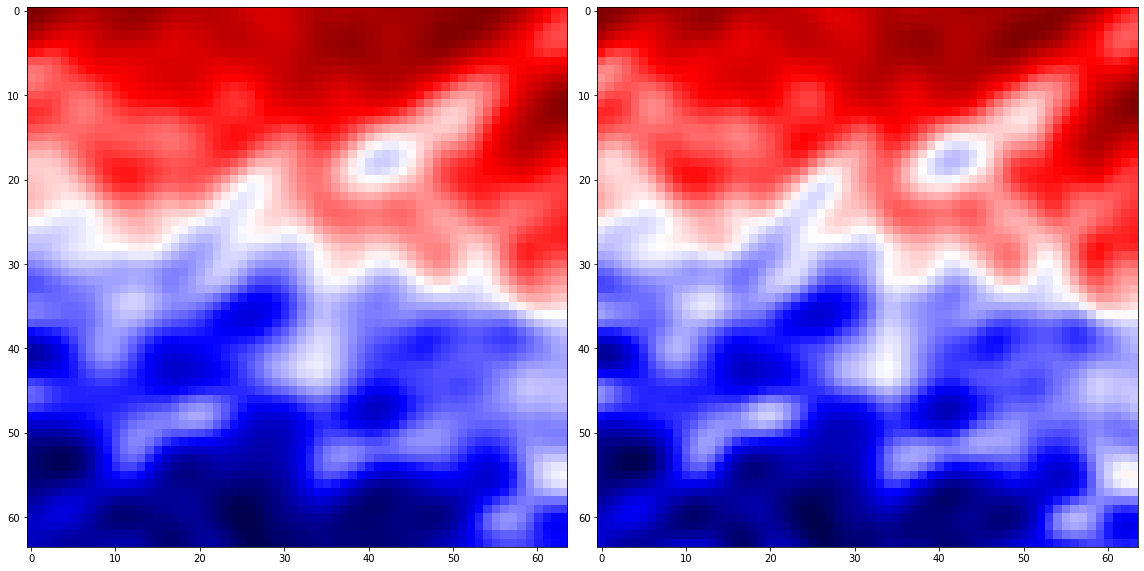

In [20]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[1], cmap='seismic')

ax[1].imshow(y_val[1], cmap='seismic')

plt.tight_layout()
plt.show()

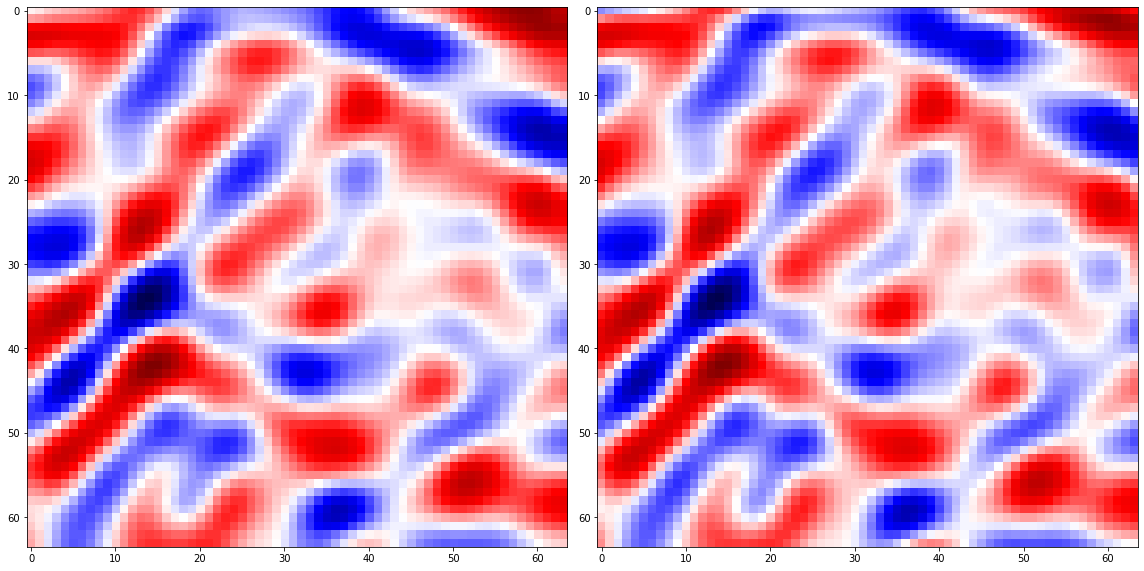

In [67]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y_b[21], cmap='seismic')

ax[1].imshow(y_val[21], cmap='seismic')

plt.tight_layout()
plt.show()